In [40]:
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=2)
sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
df_yeast = pd.read_table('../PNAS_2000_datasets/Yeast.txt', header=1)
df_yeast= df_yeast.loc[:, '0_min':]
df_yeast = df_yeast.replace('Null', np.nan)
df_yeast = df_yeast.astype(float)

In [12]:
df_human = pd.read_table('../PNAS_2000_datasets/Human.txt', header=1)
df_human = df_human.loc[:, '2_hr':]
df_human = df_human.replace('Null', np.nan)
df_human = df_human.astype(float)
non_null_idx = df_human.dropna().index
null_idx

array([    0,     1,     2, ..., 12052, 12054, 12055])

# Imputing using the SVD

- Learn a set of basis functions or eigne-genes from the compelete data
- Impute the missing cells for a gene by regressing its non-missing entries on the eigen genes
and use the regression function to predict values at missing locations

Consider $X_{n \times m}$ array where the rows are the genes and columns are the tissues. so $n > m$.
Let $X^c$ be the complete set of genes and $X^m$ be the set of genes with at least one missing
entry per row.

A rank $k$ SVD  is given by:

$$
X^{(k)} + U_{n \times k} \Sigma_{k \times k} V^T_{m \times k}
$$

Alternatively, it satisfies the following criteria:

$$
\min_{X^{(k)}} ||X-X^{(k)}||_F^2
$$


The eigen-genes $v_1, v_2, v_3, \dots v_k$ are each $1 \times m$ vector. Granulary, for a given row $g_i$ $({1 \times m})$ belonging
to matrix $X_{n \times m}$ the above two equations are solving the following least squares regression problem:

$$
\min_{\beta} || g_{i} - V_J\beta||^2 = \min_{\beta} \sum_{l=1}^p (g_{il} - \sum_{j=1}^J v_{lj}\beta_j)^2
$$

The OLS solution is:

$$
\hat{\beta} = (V_J^TV_J)^{-1}V_J^Tg_i = V_J^Tg_i
$$

as $V_J$ is orthogonal.

The fitted values are then given by $\hat{g_i} = V_J\hat{\beta}$ and hence $X^cV_J = U_J\Sigma_J$ gives us all the regression coefficients for all the rows while
the fitted values are given by $\hat{X}^c = U_J\Sigma_J V_J^T$. As long as $V_J$ can  be found, the SVD can be thought of as approximating each row of $X^c$ 
by its fitted vector obtained using regression on $V_J$.


For a row $g_i$ of $X^m$, with some of the components missing, we can impute the missing values by:

$$\min_\beta \sum_{ l \text{ non-missing}} (g_{il} - \sum_{j=1}^J v_{lj} \beta_j)^2$$


Consider $V_{J^*}$ to be a shorter version of $V_J$ obtained after removing rows corresponding to those of missing values in $X$.
The OLS solution is given by

$$
\hat{\beta} (V_{J^*}^TV_{J^*})^{-1}V_{J^*}^Tg_i 
$$

As the columns of $V_{J^*}$ are not necessarily orthonormal anymore, we can't reduce it further like we did earlier..

NOTE: None of the above regressions have an intercept term. Hence it is customary to center the data before doing SVD. his means
that the $i^{\text{th}}$ row mean should  be subtracted from each row of $X$. However columns of $V_{J^*}$ are no longer zero mean
and hence need to select an intercept explicitly.


In [63]:
def SVD_impute(df):
    """Perform SVD imputing.
    
    
    Parameters
    ----------
    matrix: array_like
            Array with rows as genes and columns as tissues/samples
            with nans for missing values
    
    Returns
    -------
    filled_matrix: array_like
                   Imputed matrix with entries filled by relying on eigengenes    
    """
    
    null_idx = pd.isnull(df).any(1).nonzero()[0]

    full_matrix = df.values
    non_null_matrix  = df.dropna().values
    U, S, V_T = np.linalg.svd(non_null_matrix)
    V =  V_T.T
    
    for index in null_idx:
        x = full_matrix[index,:]

        # index of entries where the row is nan
        row_na_idx = np.where(np.isnan(x))
        
        # index of entries where the row is not nan        
        row_not_na_idx = np.where(~np.isnan(x))
        
        
        # entries from row which are not nan        
        x_star_not_na = x[row_not_na_idx]
        
         # entries from row which are not nan        
        x_star_na = x[row_na_idx]

        # Eigen genes corresponding to index 
        # of locations (columns) in row x which are nan
        V_star_na = np.delete(V, row_not_na_idx, 0)
        
        
        # Delete rows from V, corresponding to index 
        # of locations (columns) in row x which are nan
        # We will use these to project the row with complete
        V_star_not_na = np.delete(V, row_na_idx, 0)


        gram = np.dot(V_star_not_na.T, V_star_not_na)
        coeff = np.dot(np.linalg.pinv(gram), V_star_not_na.T)

        beta = np.dot(coeff, x_star_not_na)
        
        # xhat = V_J \beta
        x_missing = np.dot(V_star_na, beta)
        
        # Fill in the missing entries
        full_matrix[index, row_na_idx] = x_missing
    return full_matrix

def plot_SVD_utils(U, S, VT):
    V = VT.T
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
    ax = axes[0, 0]
    sns.heatmap(V, square=True, cmap='RdBu', ax=ax, cbar=False)
    
    ax = axes[0, 1]
    sns.barplot(x=np.arange(1, len(S)+1), y=S**2/np.sum(S**2), ax=ax, color=sns.color_palette('Set2')[1])
    
    ax = axes[0, 2]
    ax.plot(V[:, 0], marker='o')
    
    ax = axes[1, 0]
    ax.plot(V[:, 1], marker='o')
    
    ax = axes[1, 1]
    ax.plot(V[:, 2], marker='o')
    
    ax = axes[1, 2]
    ax.plot(V[:, 3], marker='o')
    
    
    
    
    

In [60]:
full_matrix_human = SVD_impute(df_human)
full_matrix_yeast = SVD_impute(df_yeast)

In [61]:
U_yeast, S_yeast, VT_yeast = np.linalg.svd(full_matrix_yeast)
U_human, S_human, VT_human = np.linalg.svd(full_matrix_human)

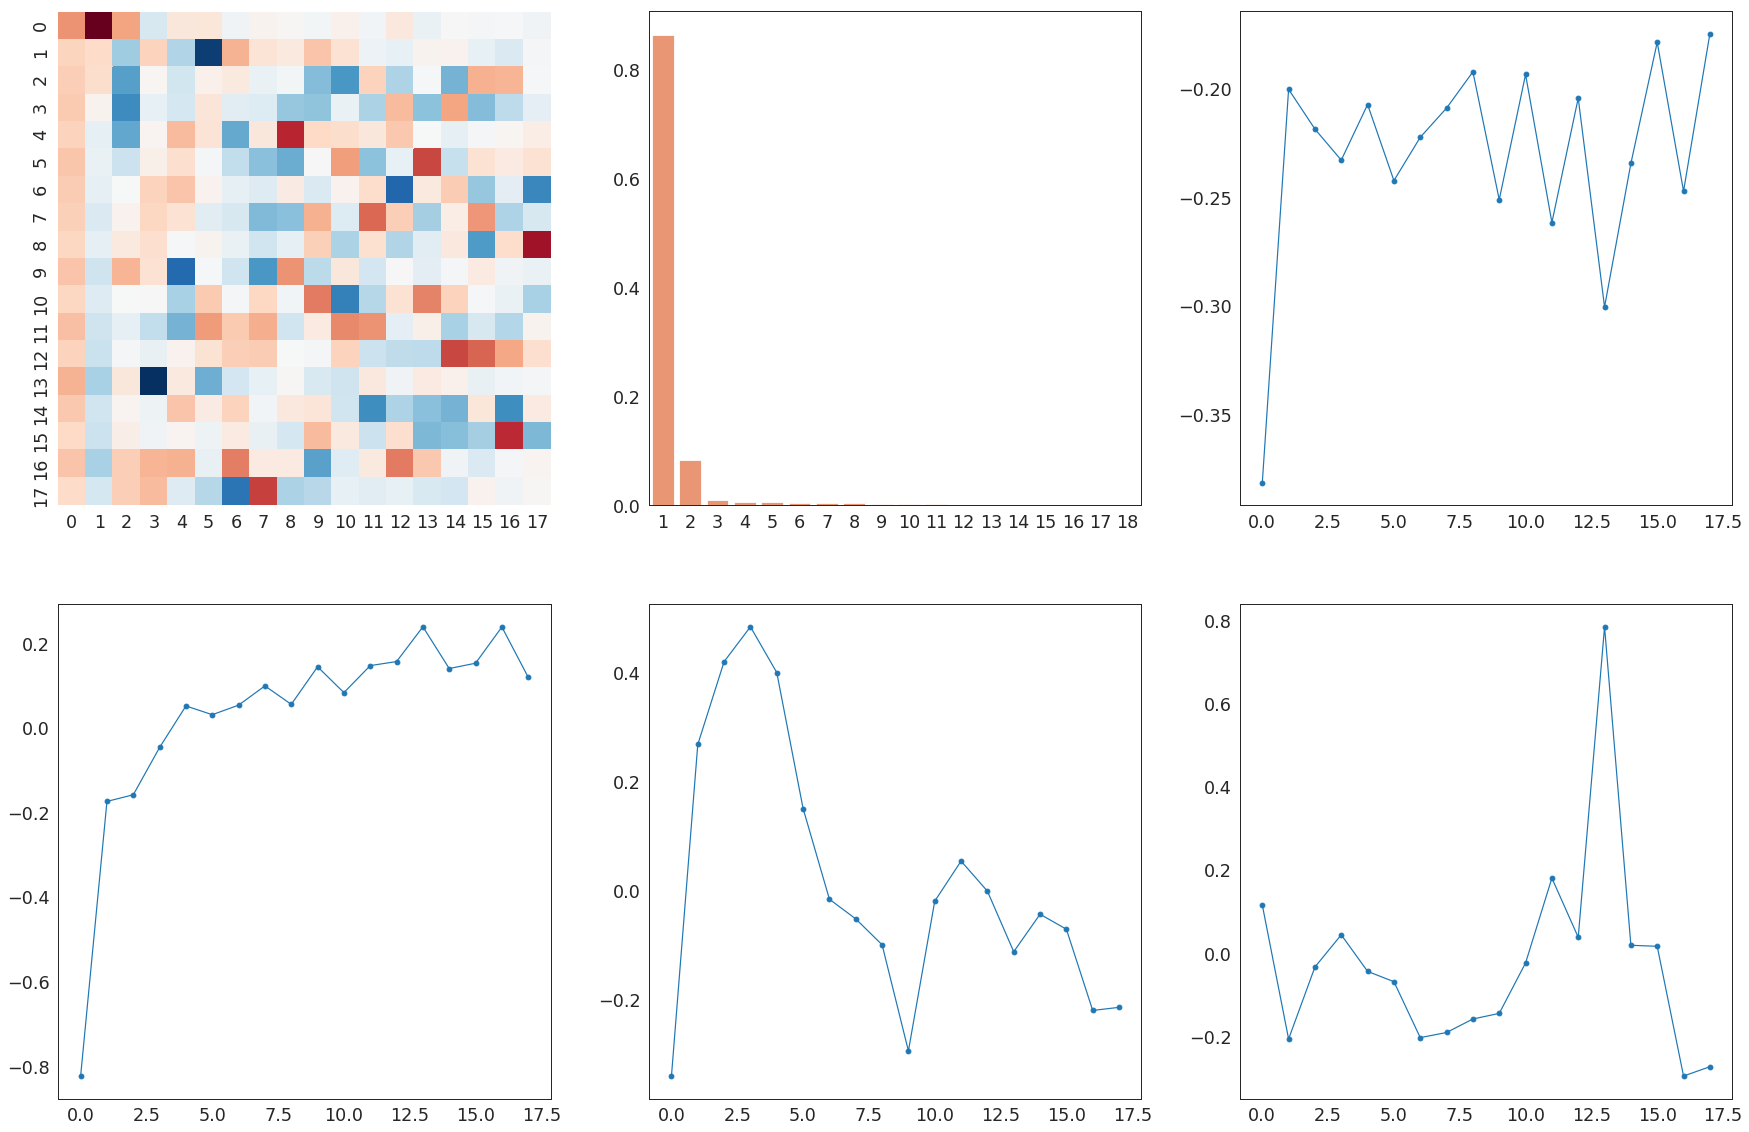

In [64]:
plot_SVD_utils(U_yeast, S_yeast, VT_yeast )

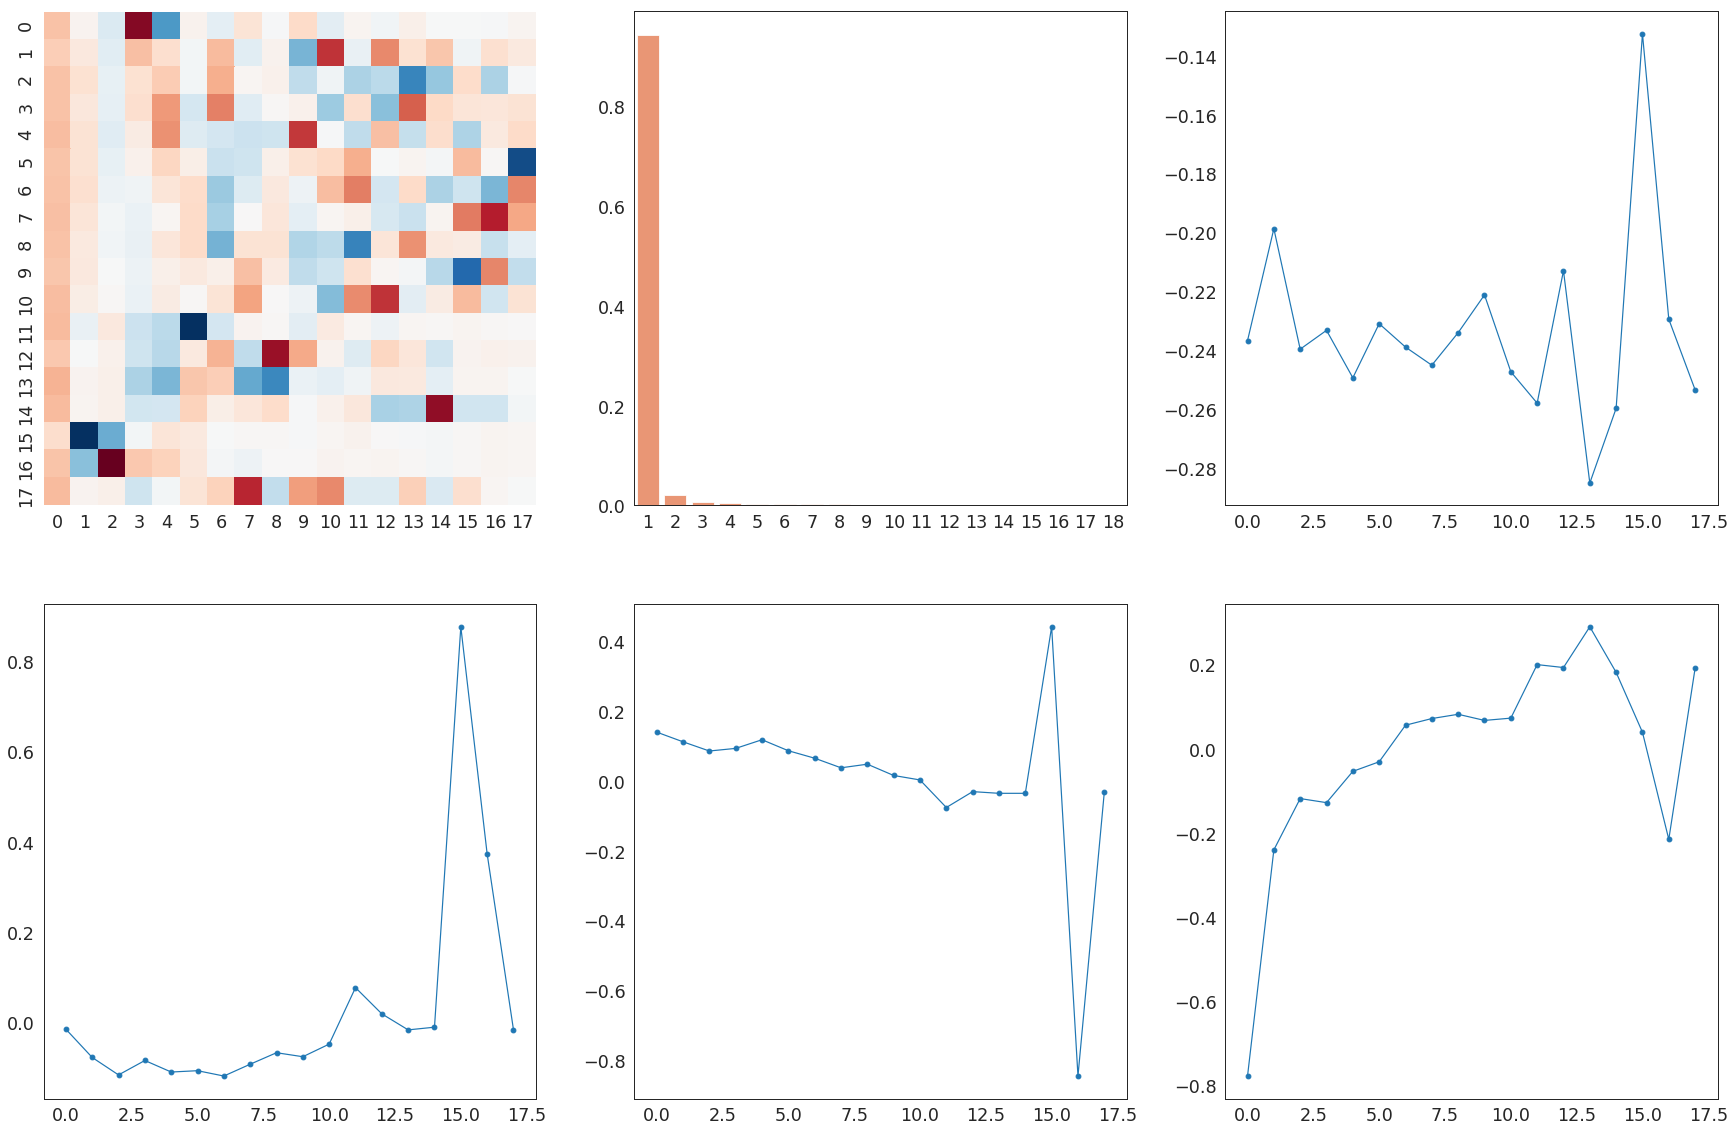

In [65]:
plot_SVD_utils(U_human, S_human, VT_human)